c:\Users\cjpai\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Close               1.000000
Yearly_MA           0.990119
ATR                 0.939152
Year                0.673189
OBV                 0.572743
Garman Klass Vol    0.564342
RSI                 0.085077
Month               0.034955
Day                 0.002768
Name: Close, dtype: float64


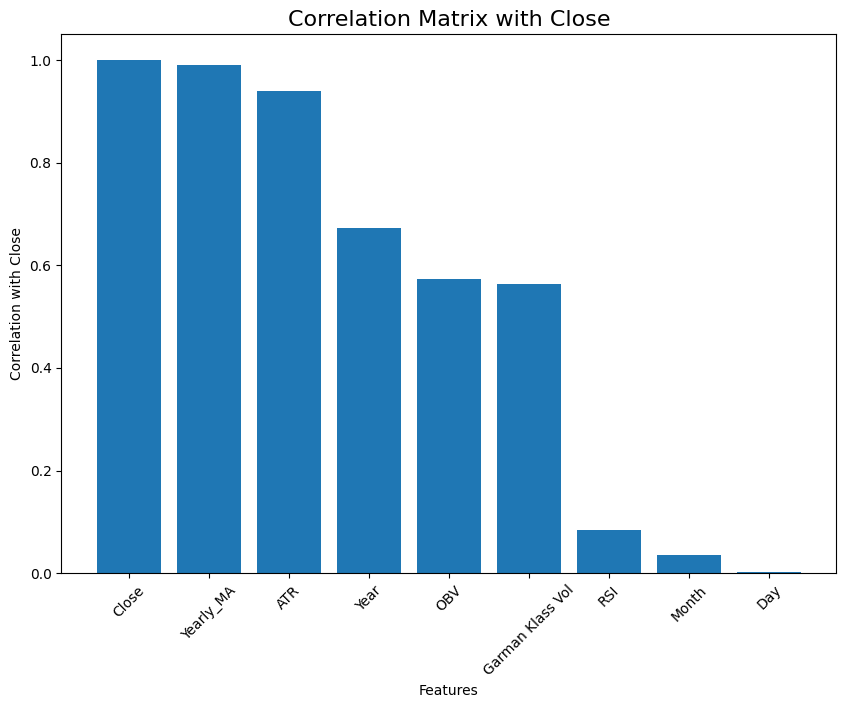

Epoch 1/100
106/106 - 8s - loss: 24.7394 - val_loss: 24.4785 - 8s/epoch - 76ms/step
Epoch 2/100
106/106 - 4s - loss: 24.2170 - val_loss: 23.9597 - 4s/epoch - 38ms/step
Epoch 3/100
106/106 - 4s - loss: 23.7030 - val_loss: 23.4500 - 4s/epoch - 37ms/step
Epoch 4/100
106/106 - 4s - loss: 23.1970 - val_loss: 22.9475 - 4s/epoch - 38ms/step
Epoch 5/100
106/106 - 4s - loss: 22.6989 - val_loss: 22.4534 - 4s/epoch - 39ms/step
Epoch 6/100
106/106 - 4s - loss: 22.2085 - val_loss: 21.9664 - 4s/epoch - 39ms/step
Epoch 7/100
106/106 - 4s - loss: 21.7256 - val_loss: 21.4875 - 4s/epoch - 38ms/step
Epoch 8/100
106/106 - 4s - loss: 21.2502 - val_loss: 21.0153 - 4s/epoch - 38ms/step
Epoch 9/100
106/106 - 4s - loss: 20.7821 - val_loss: 20.5508 - 4s/epoch - 38ms/step
Epoch 10/100
106/106 - 4s - loss: 20.3211 - val_loss: 20.0935 - 4s/epoch - 38ms/step
Epoch 11/100
106/106 - 4s - loss: 19.8671 - val_loss: 19.6430 - 4s/epoch - 38ms/step
Epoch 12/100
106/106 - 4s - loss: 19.4201 - val_loss: 19.1991 - 4s/epoch -

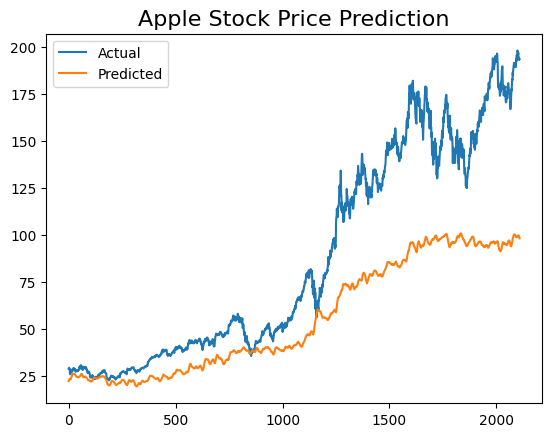

Epoch 1/100
106/106 - 5s - loss: 0.3117 - val_loss: 0.2949 - 5s/epoch - 45ms/step
Epoch 2/100
106/106 - 5s - loss: 0.2784 - val_loss: 0.2630 - 5s/epoch - 43ms/step
Epoch 3/100
106/106 - 5s - loss: 0.2477 - val_loss: 0.2335 - 5s/epoch - 45ms/step
Epoch 4/100
106/106 - 5s - loss: 0.2194 - val_loss: 0.2063 - 5s/epoch - 49ms/step
Epoch 5/100
106/106 - 5s - loss: 0.1934 - val_loss: 0.1816 - 5s/epoch - 47ms/step
Epoch 6/100
106/106 - 5s - loss: 0.1697 - val_loss: 0.1590 - 5s/epoch - 50ms/step
Epoch 7/100
106/106 - 5s - loss: 0.1481 - val_loss: 0.1383 - 5s/epoch - 48ms/step
Epoch 8/100
106/106 - 5s - loss: 0.1285 - val_loss: 0.1198 - 5s/epoch - 48ms/step
Epoch 9/100
106/106 - 5s - loss: 0.1109 - val_loss: 0.1030 - 5s/epoch - 48ms/step
Epoch 10/100
106/106 - 5s - loss: 0.0951 - val_loss: 0.0882 - 5s/epoch - 47ms/step
Epoch 11/100
106/106 - 5s - loss: 0.0810 - val_loss: 0.0748 - 5s/epoch - 46ms/step
Epoch 12/100
106/106 - 5s - loss: 0.0685 - val_loss: 0.0631 - 5s/epoch - 44ms/step
Epoch 13/100


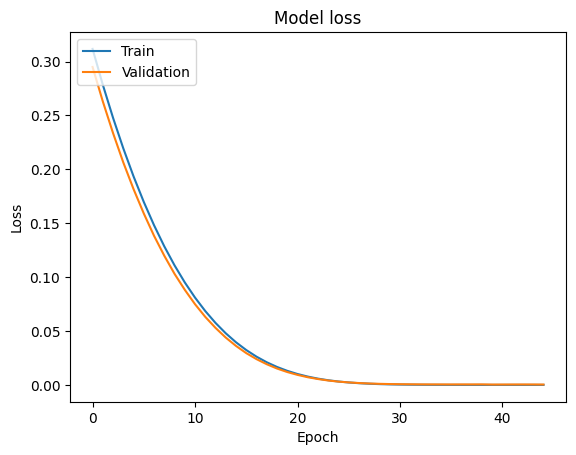

The model is overfitting


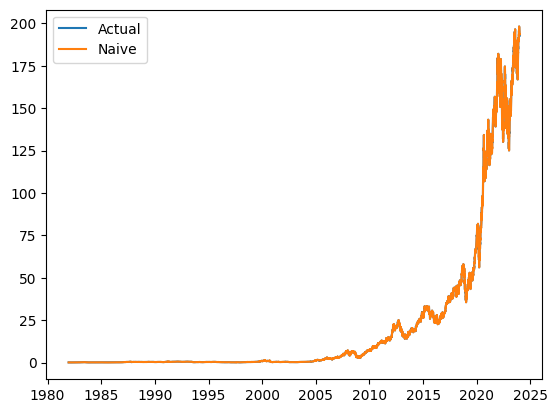

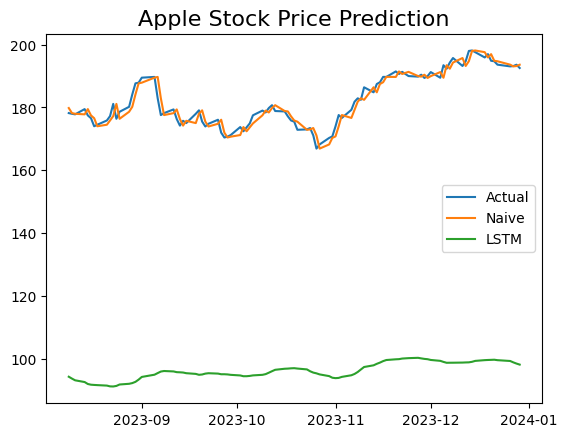

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta 

# Load the data
data = yf.download('AAPL', start='1980-12-12', end='2024-01-01')

# Add new features
data['RSI'] = ta.rsi(data['Close'])
data['OBV'] = ta.obv(data['Close'], data['Volume'])
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'])
data['Yearly_MA'] = data['Close'].rolling(window=256).mean()
data['Garman Klass Vol'] = ((np.log(data['High']) - np.log(data['Low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(data['Adj Close']) - np.log(data['Open'])) ** 2)
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month
data['Year'] = data.index.year

# Drop missing values
data = data.dropna()

# Keep only the 'Close' and the new features
data = data[['Close', 'RSI', 'OBV', 'ATR', 'Yearly_MA', 'Garman Klass Vol', 'Day', 'Month', 'Year']]

# Create a correlation matrix with the target 'Close'
correlation_matrix = data.corr()['Close'].sort_values(ascending=False)
print(correlation_matrix)

# Visualize correlation matrix, so we can read each feature clearly
plt.figure(figsize=(10, 7))
plt.bar(correlation_matrix.index, correlation_matrix.values)
plt.title('Correlation Matrix with Close', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Correlation with Close')
plt.xticks(rotation=45)
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Create a separate scaler for 'Close' prices
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(data[['Close']])

# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled.iloc[0:train_size, :], data_scaled.iloc[train_size:len(data_scaled), :]

# Function to create a dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1:]  # Use only the features for input
        X.append(a.values)
        Y.append(dataset.iloc[i + look_back, 0])  # Use 'Close' for output
    return np.array(X), np.array(Y)

# Create datasets for training and testing
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001)

model = Sequential()
model.add(LSTM(250, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), bias_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.2))
model.add(LSTM(250, bias_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=2, validation_split=0.2, callbacks=[early_stopping])

# Predict the stock prices on the testing data
predictions = model.predict(X_test)
predictions = close_scaler.inverse_transform(predictions)  # Use the 'close_scaler' here

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate the RMSE, MSE and R² for the test set
Y_test_transformed = close_scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Calculate the RMSE, MSE, and R² for the test set
mae = mean_absolute_error(Y_test_transformed, predictions.flatten())
mse = mean_squared_error(Y_test_transformed, predictions.flatten())
r2 = r2_score(Y_test_transformed, predictions.flatten())

print('MAE:', mae)
print('MSE:', mse)
print('R²:', r2)

# Calculate the average difference between the actual and predicted values as a percentage
average_difference = np.mean(np.abs(predictions.flatten() - Y_test_transformed) / Y_test_transformed) * 100
print(f"Average difference between actual and predicted values: {average_difference:.2f}%")

# Compare the predicted prices with the actual values
Y_test = close_scaler.inverse_transform([Y_test])  # Use the 'close_scaler' here
plt.plot(Y_test[0])
plt.plot(predictions[:, 0])
plt.title('Apple Stock Price Prediction', fontsize=16)
plt.legend(['Actual', 'Predicted'])
plt.show()

# Plot train loss vs validation loss
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=2, validation_split=0.2, callbacks=[early_stopping])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print overfitting or not
if history.history['val_loss'][-1] < history.history['loss'][-1]:
    print('The model is not overfitting')
else:
    print('The model is overfitting')

# Create a Niave forecast
data['Naive'] = data['Close'].shift(1)
data = data.dropna()

# Plot the naive forecast
plt.plot(data['Close'], label='Actual')
plt.plot(data['Naive'], label='Naive')
plt.legend()
plt.show()

# Compare Niave forecast with LSTM forecast
plt.plot(data['Close'][-100:], label='Actual')
plt.plot(data['Naive'][-100:], label='Naive')
plt.plot(data['Close'][-100:].index, predictions[-100:], label='LSTM')
plt.title('Apple Stock Price Prediction', fontsize=16)
plt.legend()
plt.show()